<a href="https://colab.research.google.com/github/AlexMan2000/DS-GA-1018-Project/blob/master/DS_GA_1018_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
!pip install mido pretty_midi music21 # Extract midi file data
!pip install kagglehub
!pip install muspy # For model evaluation
!sudo apt install musescore3 -y  # For music score visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=8f903b54afb9a8c0566bedddf7ff8fb096ddf948555719324296ae37b88886c3
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 5.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin
  libinput10 libmd4c0 libmtdev1 libpoppler-qt5-1 libportaudio2 libportmidi0
  libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5 libqt5network5
  libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 li

# Environments

In [ ]:
import os
from google.colab import drive
import shutil
import kagglehub
from typing import Any, Tuple
import types

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
import pandas as pd
from tqdm.notebook import tqdm
import pickle
from keras.utils import to_categorical
import copy

# Music-related
from music21 import *
import muspy

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/MyDrive/DS-GA-1018"
DATA_PATH = os.path.join(BASE_PATH, "data")
MIDI_PATH = os.path.join(DATA_PATH, "midi")
DATASET_PATH = os.path.join(BASE_PATH, "dataset")
MODEL_PATH = os.path.join(BASE_PATH, "model")
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MIDI_PATH, exist_ok=True)
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

# Datasets

## Download Datasets

In [ ]:
# Download latest version
dataset_cache_path = kagglehub.dataset_download("soumikrakshit/classical-music-midi")
shutil.copytree(dataset_cache_path, MIDI_PATH, dirs_exist_ok=True)

100%|██████████| 2.33M/2.33M [00:00<00:00, 130MB/s]

Extracting files...


## Load Datasets

### Dataset Description

Below is the mapping between notes name and its Midi number representation for your references.

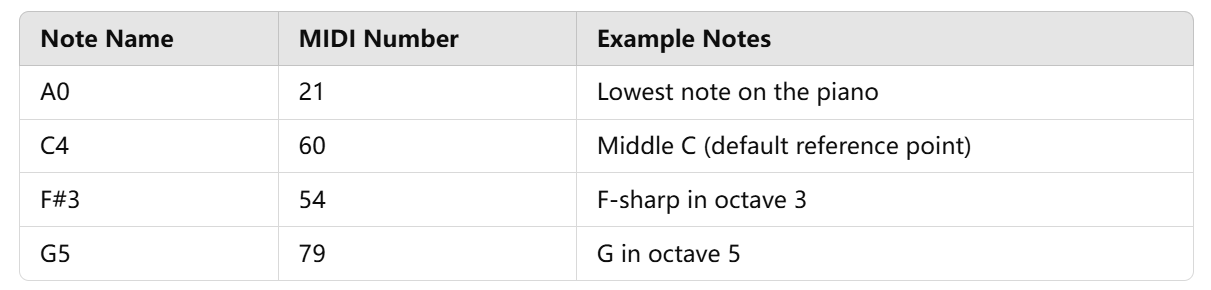

The datasets contain music scores from different pianists, including Bach, Chopin etc. The following shows a sample music score decoded from midi file.

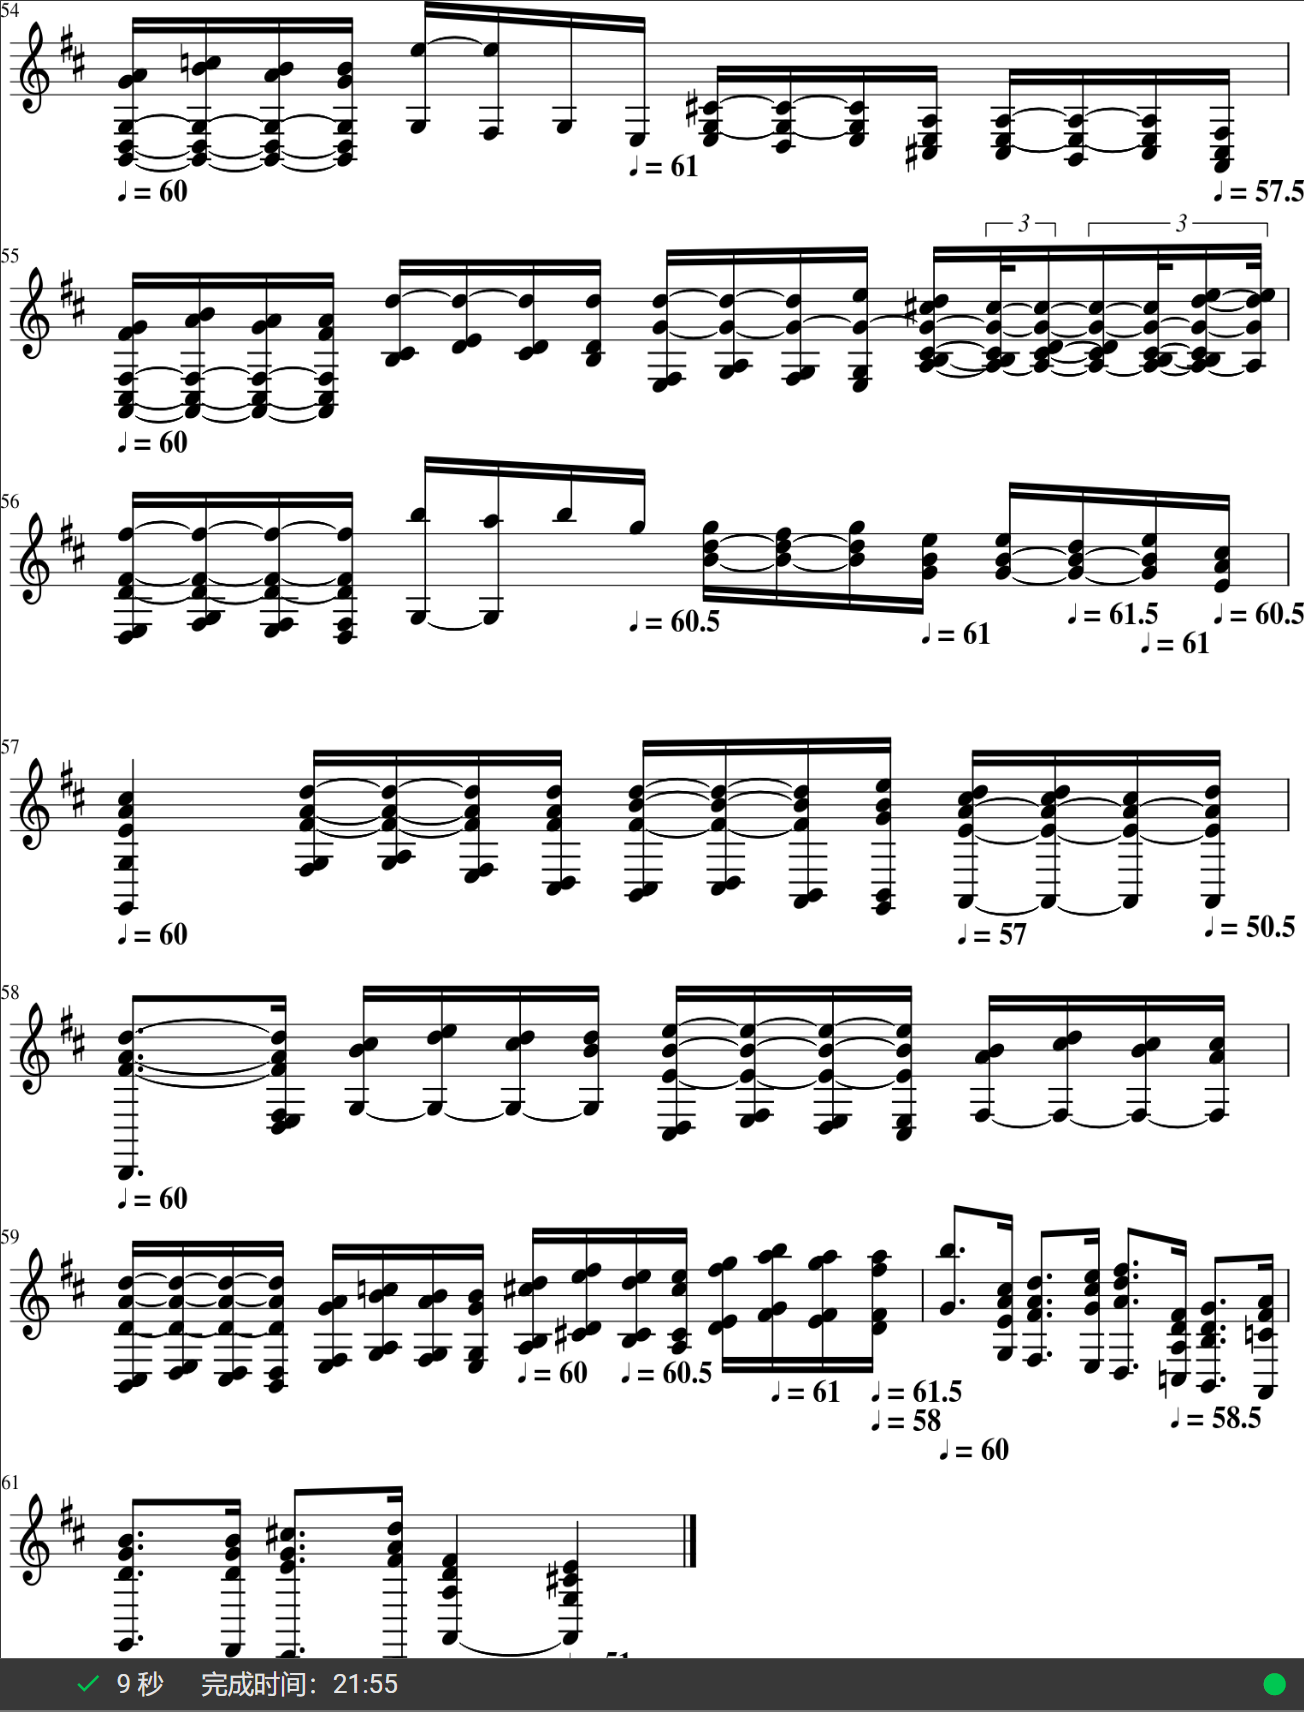

### Helper Functions

Document Reference: https://www.music21.org/music21docs/index.html

In [ ]:
def encode_frequency(frequency_list):
  """
  An invertible encoding function for frequency

  [445, 875, 345] => base 31  => 345 + 875 * 31 + 445 * 31**2 => number

  """
  return np.mean(frequency_list)

def decode_frequency(frequency_obj):
  """
  A function to decode from the frequency object to a list of frequencies
  """
  pass

def encode_octave(octave_list):
  """
  An invertible encoding function for octave
  """
  return np.mean(octave_list)

def decode_octave(octave_obj):
  """
  A function to decode from the octave object to a list of octaves
  """
  pass

def encode_pitch_class(pitch_class_list):
  """
  An invertible encoding function for pitch class
  """
  return np.mean(pitch_class_list)

def decode_pitch_class(pitch_class_obj):
  """
  A function to decode from the pitch class object to a list of pitch classes
  """
  pass


def encode_duration(duration) -> float:
  """
  An invertible encoding function for duration

  examples:
  >>> duration = duration.Duration(0.33333333)
  >>> quarterLength = duration.quarterLength   # Fraction(1, 3)
  >>> encode_duration(quarterLength)
  0.3333333333
  """
  return float(duration)

def decode_duration(float_duration):
  """
  A function to decode from the duration object to a list of durations
  examples:
  >>> float_duration = 0.333333333333
  >>> decode_duration(0.3333333333)
  Fraction(1, 3)
  """
  return duration.Duration(float_duration).quarterLength


def extract_feature(
  midi_score
  ,filename=None
  ,frequency_extractor=None
  ,octave_extractor=None
  ,pitch_class_extractor=None
  ,duration_extractor=None
  ,add_feature_list=["octave", "frequency", "pitchClass", "root"]
  ,mode="build"
  ,create_cache=False
  ):
  """
  This function will transform a midi file to the a list of notes and chords, along with their durations.

  @param The filename for cache purpose
  @param midi_score: The music score,which could be displayed using score.show() directly
  @param frequency_extractor: None | A function to map from a list of frequencies to a single value
  @param octave_extractor: None | A function to map from a list of octaves to a single value
  @param pitch_class_extractor: None | A function to map from a list of pitch classes to a single value
  @param add_feature_list: None | A list of features to be extracted on top of notes and durations
  @param create_cache: boolean, whether to create a cache for this particular music midi score
  @return: A feature object

  example usages:
  >>> file = "bach_837.mid"
  >>> midi = converter.parse(file).chordify()
  >>> extract_feature(midi)
  {
    "notes": ["A1", "C#3", "A6", "C3.E3.G3", "rest", ...],     List<str>
    "durations": [1, 0.25, Fraction(1, 12), 1, 2, ...], unit is beat,      List<int>
    "octave": [1, 3, 6, [3, 3, 3] => 3, None,....],          List<int>, 八度音区, C3 => 3, C4 => 4
    "pitchClass": [9, 1, 9, [1, 4, 7] => 4, None,....],          List<int>, 一个八度内的级数
    "frequency": [235.33, 342.2145, 343.33, [445.32, 676.3, 873.34] => 687.34, None, ...],  List<float>
    "root": ["A1", 'C#3", "A6", "C3", "None", ...]          List<str>
  }
  """

  feature_list = ["notes", "durations"]

  feature_list.extend(add_feature_list)

  if mode == "build":
    features_tuple = [("notes", []), ("durations", [])]
    features_tuple.extend(list(map(lambda x: (x, []), add_feature_list)))
    features_dict = dict(features_tuple)

    for element in midi_score.flat:
      # If chords(和弦) (e.g. do3 mi3 so3 <=> C3 E3 G3 <=> C3.E3.G3)
      if isinstance(element, chord.Chord):
        features_dict["notes"].append('.'.join(n.nameWithOctave for n in element.pitches))
        if duration_extractor is None:
          features_dict["durations"].append(element.duration.quarterLength)
        elif isinstance(duration_extractor, types.FunctionType):
          features_dict["durations"].append(duration_extractor(element.duration.quarterLength))



        for add_feature in add_feature_list:
          if add_feature == "octave":
            # 没有音区的话默认中央 => 3
            octaves = [oc.octave if oc.octave is not None else 3 for oc in element.pitches]
            if octave_extractor is None or octave_extractor == "mean":
              # By default, 就求均值
              features_dict["octave"].append(np.mean(octaves))
            elif isinstance(octave_extractor, types.FunctionType):
              # 传入函数，就执行函数
              features_dict["octave"].append(octave_extractor(octaves))
          elif add_feature == "pitchClass":
            pitches = [oc.pitchClass for oc in element.pitches]
            if pitch_class_extractor is None or pitch_class_extractor == "mean":
              # By default, 就求均值
              features_dict["pitchClass"].append(np.mean(pitches))
            elif isinstance(pitch_class_extractor, types.FunctionType):
              features_dict["pitchClass"].append(pitch_class_extractor(pitches))
          elif add_feature == "frequency":
            frequencies = [oc.frequency for oc in element.pitches]
            if frequency_extractor is None or frequency_extractor == "mean":
              # By default, 就求均值
              features_dict["frequency"].append(np.mean(frequencies))
            elif isinstance(frequency_extractor, types.FunctionType):
              features_dict["frequency"].append(frequency_extractor(frequencies))
          elif add_feature == "root":
            features_dict["root"].append(element.root().nameWithOctave)

      if isinstance(element, note.Note):
        if element.isRest:
          # If rest note(休止符), 没有任何额外feature可用
          features_dict["notes"].append(str(element.name))
          features_dict["durations"].append(element.duration.quarterLength)
          for add_feature in add_feature_list:
            if add_feature == "octave":
              features_dict["octave"].append(None)
            elif add_feature == "frequency":
              features_dict["frequency"].append(None)
            elif add_feature == "root":
              features_dict["root"].append(None)
            elif add_feature == "pitchClass":
              features_dict["pitchClass"].append(None)
        else:
          # If it is a note (e.g. do 3 <=> C3)
          features_dict["notes"].append(str(element.nameWithOctave))
          features_dict["durations"].append(element.duration.quarterLength)

          for add_feature in add_feature_list:
            if add_feature == "octave":
              features_dict["octave"].append(element.pitch.octave)
            elif add_feature == "frequency":
              features_dict["frequency"].append(element.pitch.frequency)
            elif add_feature == "root":
              features_dict["root"].append(str(element.nameWithOctave))
            elif add_feature == "pitchClass":
              features_dict["pitchClass"].append(element.pitch.pitchClass)

    if create_cache:
      assert filename is not None, "Please specify the filename to cache"
      os.makedirs(os.path.join(DATASET_PATH, "features"))
      os.makedirs(os.path.join(DATASET_PATH, "feature_list"))
      with open(os.path.join(DATASET_PATH, "features", filename), "wb") as f:
        pickle.dump(features_dict, f)
      with open(os.path.join(DATASET_PATH, "feature_list", filename), "wb") as f:
        pickle.dump(features_dict, f)
    return features_dict, feature_list
  else:
    assert filename is not None, "Please specify the filename to cache"
    filepath = os.path.join(DATASET_PATH, "features", filename)
    if os.path.exists(filepath):
      with open(os.path.join(DATASET_PATH, "features", filename), "rb") as f:
        features_dict = pickle.load(f)
      with open(os.path.join(DATASET_PATH, "feature_list", filename), "rb") as f:
        features_list = pickle.load(f)
      return features_dict, feature_list
    else:
      raise FileNotFoundError("File not found")



def extract_all_features(
    pianoists
    ,file_type="midi"
    ,features_list=["notes", "durations", "octave", "frequency", "pitchClass", "root"]
    ,mode="build"):
  """
  This function will transform a list of midi files to a list of feature objects

  @param pianoist: a list of pianoists ["bach", "mozart"]
  @param file_type
  @param feature_list: all the feature that should be extracted from the midi file, the first two should be ["notes", "durations"]

  example usages:
  >>> features = extract_all_features(["bach", "mozart"])
  >>> features
  {
    "bach_847.mid": {
      {
        "notes": ["A1", "C#3", "A6", "C3.E3.G3", "rest", ...],     List<str>
        "durations": [1, 0.25, Fraction(1, 12), 1, 2, ...], unit is beat,      List<int>
        "octave": [1, 3, 6, [3, 3, 3] => 3, None,....],          List<int>, 八度音区, C3 => 3, C4 => 4
        "pitchClass": [9, 1, 9, [1, 4, 7] => 4, None,....],          List<int>, 一个八度内的级数
        "frequency": [235.33, 342.2145, 343.33, [445.32, 676.3, 873.34] => 687.34, None, ...],  List<float>
        "root": ["A1", 'C#3", "A6", "C3", "None", ...]          List<str>
      }
    },
    "bach_846.mid": {
      ...
    },
    "bach_850.mid":{
      ...
    },
    "mozart_744.mid": {
      ...
    }
  }
  # If you have built before, then use mode="cache"
  >>> features = extract_all_features(["bach", "mozart"], mode="cache")
  >>> features
  ...
  """

  added_features = []

  for feature in features_list:
    if feature not in ["notes", "durations", "octave", "frequency", "pitchClass", "root"]:
      raise ValueError("Invalid feature")
    if feature in ["octave", "frequency", "pitchClass", "root"]:
      added_features.append(feature)

  if mode == "build":
    feature_dict = {}


    # Currently only midi file
    if file_type == "midi":
      os.makedirs(os.path.join(DATASET_PATH, "features"), exist_ok=True);
      for folder in tqdm(os.listdir(os.path.join(MIDI_PATH))):
        if folder in pianoists:
          for filename in tqdm(os.listdir(os.path.join(MIDI_PATH, folder))):
            if filename.endswith(".mid"):
              tr = os.path.join(MIDI_PATH, folder, filename)
              original_score_midi = converter.parse(tr).chordify()
              features, feature_list = extract_feature(midi_score=original_score_midi, add_feature_list=added_features)
              feature_dict[filename] = features
              with open(os.path.join(DATASET_PATH, "features", "feature_list"), "wb") as f:
                pickle.dump(feature_list, f)

    with open(os.path.join(DATASET_PATH, "features", "feature"), "wb") as f:
      pickle.dump(feature_dict, f)
    with open(os.path.join(DATASET_PATH, "features", "meta_feature"), "wb") as f:
      pickle.dump(pianoists, f)

    return feature_dict
  else:
    with open(os.path.join(DATASET_PATH, "features", "feature"), "rb") as f:
      feature_dict = pickle.load(f)
    with open(os.path.join(DATASET_PATH, "features", "meta_feature"), "rb") as f:
      pianoists_cached = pickle.load(f)
    with open(os.path.join(DATASET_PATH, "features", "feature_list"), "rb") as f:
      feature_list_cached = pickle.load(f)
    if pianoists_cached != pianoists:
      raise ValueError("There are some pianoists' midi files that you haven't processed, call the method with mode=build again!")

    # Pick the feature that's specified
    for folder in tqdm(os.listdir(os.path.join(MIDI_PATH))):
      if folder in pianoists:
        for filename in tqdm(os.listdir(os.path.join(MIDI_PATH, folder))):
          if filename.endswith(".mid"):

            # print(feature_dict[filename].keys())
            for feature in added_features:
              if feature not in feature_dict[filename].keys():
                print(f'Feature name: {feature} is not cached, please re-extract the feature using mode="build"')

            keys = copy.deepcopy(list(feature_dict[filename].keys()))
            for feature in keys:
              if feature not in added_features and feature not in ["notes", "durations"]:
                del feature_dict[filename][feature]


    return feature_dict


def play_notes(note_sequence):
  """
  This function takes a list of notes and play them out.

  @param note_sequence: A list of notes
  @return: None

  example usages:
  >>> note_sequence = ["A", "C", "F#", "G#3", "A", "F#3.A#3.C4#", ...]
  >>> play_notes(note_sequence)
  ...
  """
  # Create a music21 stream
  s = stream.Stream()

  for n in note_sequence:
    if '.' in n:  # It's a chord, e.g. F#3.A#3.C4# => F# major
      pitches = [p for p in n.split('.')]
      chord_obj = chord.Chord(pitches)
      s.append(chord_obj)
    else:  # It's a single note
      note_obj = note.Note(n)
      s.append(note_obj)

  # Play the stream
  s.show('midi')

def play_notes_with_duration(note_sequence, duration_sequence):
  """
  Plays a sequence of notes or chords with durations.

  @param note_sequence: A list containing notes or chords with durations.
                        - Single notes: represented as strings (e.g., "A", "G#3").
                        - Chords: represented as strings with pitches separated by
                          periods and followed by duration after a colon (e.g., "F#3.A#3.C4#:1.5").

  @param duration_sequence: A list containing duration corresponds to notes or chords

  @return: None
  """
  s = stream.Stream()

  for n, d in zip(note_sequence, duration_sequence):
    if '.' in n:  # It's a chord, e.g. F#3.A#3.C4# => F# major
      pitches = [p for p in n.split('.')]
      chord_obj = chord.Chord(pitches)
      chord_obj.duration = duration.Duration(d)
      s.append(chord_obj)
    else:  # It's a single note
      note_obj = note.Note(n)
      note_obj.duration = duration.Duration(d)
      s.append(note_obj)

  s.show('midi')  # Play the music
  s.write('midi', fp=filename)

### Load Midi Files

In [ ]:
# 3 min execution for chopin midi folder
all_original_scores= []
MUSIC_FOLDER = "bach"  # 可更改，现在是巴赫
for filename in tqdm(os.listdir(os.path.join(MIDI_PATH, MUSIC_FOLDER))):
  if filename.endswith(".mid"):
    tr = os.path.join(MIDI_PATH, MUSIC_FOLDER, filename)
    # 把一起弹的音当作和弦来处理
    midi = converter.parse(tr).chordify()
    all_original_scores.append(midi)

  0%|          | 0/3 [00:00<?, ?it/s]

### Testing Utilities

In [ ]:
# Playing chords
# Define the chords for the progression 4-5-3-6-2-5-1
chord_4 = chord.Chord([note.Note("F3"), note.Note("A3"), note.Note("C4")])
chord_5 = chord.Chord([note.Note("G3"), note.Note("B3"), note.Note("D4")])
chord_3 = chord.Chord([note.Note("E3"), note.Note("G3"), note.Note("B3")])
chord_6 = chord.Chord([note.Note("A3"), note.Note("C4"), note.Note("E4")])
chord_2 = chord.Chord([note.Note("D3"), note.Note("F3"), note.Note("A3")])
chord_1 = chord.Chord([note.Note("C4"), note.Note("E4"), note.Note("G4")])
chord_5_2 = chord.Chord([note.Note("G3"), note.Note("B3"), note.Note("D4")])

# Set durations for each chord
for c in [chord_4, chord_5, chord_3, chord_6, chord_2, chord_5, chord_1]:
  c.duration.quarterLength = 1  # Each chord lasts 1 beat

# Create the stream and append the chords
chord_sequence = stream.Stream()
chord_sequence.append(chord_4)  # 4
chord_sequence.append(chord_5)  # 5
chord_sequence.append(chord_3)  # 3
chord_sequence.append(chord_6)  # 6
chord_sequence.append(chord_2)  # 2
chord_sequence.append(chord_5_2)  # 5 (repeated)
chord_sequence.append(chord_1)  # 1

# Play the progression
chord_sequence.show('midi')

In [ ]:
r = note.Note()

In [ ]:
score = all_original_scores[0]

In [ ]:
type(extract_feature(score))

tuple

In [ ]:
# 获取巴赫的bach_850.mid 文件中的所有notes
Corpus = list(map(lambda score: extract_feature(score)[0]["notes"], all_original_scores))

In [ ]:
note_sequence = Corpus[0][:10] # 弹前十个音
play_notes(note_sequence)

In [ ]:
extract_feature(all_original_scores[0])[0]["durations"]

[0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 Fraction(1, 12),
 Fraction(1, 6),
 Fraction(1, 6),
 Fraction(1, 12),
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 Fraction(1, 12),
 Fraction(1, 6),
 Fraction(1, 6),
 Fraction(1, 12),
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 Fraction(1, 6),
 Fraction(1, 12),
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,

In [ ]:
halfDuration = duration.Duration('half')
halfDuration.dots = 2
halfDuration.quarterLength

3.5

## Data Preprocessing

A midi file can be converted to a sequence of notes/chords(typical time series data), so we will transform this sequence into a vector sequence.




#### Helper Functions

In [ ]:
def get_distinct(elements):
  """
  This function will get all the unique elements in a list.

  @param elements: A list of elements
  @return: A tuple of (element_names, n_elements)
  """

  # Get all pitch names
  element_names = sorted(set(elements))
  n_elements = len(element_names)
  return (element_names, n_elements)


def create_lookups(element_names):
  """
  This function will create a mapping between notes and integers and vice versa.
  @param: element_names: A list of notes
  @return: A tuple of (element_to_int, int_to_element)
  """
  # create dictionary to map notes and durations to integers
  element_to_int = dict((element, number) for number, element in enumerate(element_names))
  int_to_element = dict((number, element) for number, element in enumerate(element_names))
  return (element_to_int, int_to_element)


def sample_with_temp(preds, temperature):
  if temperature == 0:
    return np.argmax(preds)
  else:
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

### Create the Corpus

In order to train Kalman Filter(LDS):

$$\begin{aligned}
\mathbf{z}_t & =\mathbf{A} \mathbf{z}_{t-1}+\mathbf{w}_t \\
\mathbf{x}_t & =\mathbf{C} \mathbf{z}_t+\mathbf{v}_t
\end{aligned}$$
, the input would be a sequence of actual music notes, we will update the parameters($A,C,Q,R$) by EM algorithm.


After training, we will use the transition function to generate future notes using the transition transfer equations.

For evaluation, we will use the muspy metric to quantify the performance of the model.

In [ ]:
# Global constant
SEQ_LEN = 32  # For LSTM seq_len
INTERVAL = range(1)  # upscale/downscale scores, for data augmentation


def get_corpus(pianoist, mode="build"):
  """
  This function will create a corpus of notes from selected pianoist for LSTM training.
  @param pianoist: A list of pianoist, or "all" for all pianoists
  @return: None
  """

  notes = []
  durations = []

  def _traverse_folder(folder):
    for filename in tqdm(os.listdir(os.path.join(MIDI_PATH, folder))):
      # Only for .mid file, not wav or whatever
      if filename.endswith(".mid"):
        tr = os.path.join(MIDI_PATH, MUSIC_FOLDER, filename)
        for interval in INTERVAL:
          original_score = converter.parse(tr).chordify()
          scaled_midi_score = original_score.transpose(interval)

          # This is for LSTM, not for Kalman Filter
          notes.extend(['START'] * SEQ_LEN)
          durations.extend([0]* SEQ_LEN)

          results, _ = extract_feature(scaled_midi_score)
          note_sequence, duration_sequence = results["notes"], results["durations"]
          notes.extend(note_sequence)
          durations.extend(duration_sequence)


  if mode == "build":
    if pianoist != "all":
      for folder in tqdm(os.listdir(os.path.join(MIDI_PATH))):
        if folder in pianoist:
          _traverse_folder(folder)
    else:
      for folder in tqdm(os.listdir(os.path.join(MIDI_PATH))):
        _traverse_folder(folder)

    os.makedirs(os.path.join(DATASET_PATH, 'supervised'), exist_ok=True)
    with open(os.path.join(DATASET_PATH, 'supervised', 'notes'), 'wb') as f:
      pickle.dump(notes, f)
    with open(os.path.join(DATASET_PATH, 'supervised', 'durations'), 'wb') as f:
      pickle.dump(durations, f)
  else:
    with open(os.path.join(DATASET_PATH, 'supervised', 'notes'), 'rb') as f:
      notes = pickle.load(f)
    with open(os.path.join(DATASET_PATH, 'supervised', 'durations'), 'rb') as f:
      durations = pickle.load(f)

  return notes, durations

In [ ]:
corpus = get_corpus(["bach"], mode="build")

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

### Encode the Corpus

In [ ]:
def get_embedding_supervised(pianoist, mode="cache"):
  """
  This function is to transform the scores into a embedding corpus

  @param pianoist: A list of pianoist, or "all" for all pianoists
  @return:
    notes: A list of all the notes, not unique
    durations: A list of all the durations, not unique
    lookups:
      Mapping from note_names to its vocab index {"A#2":1, "C#3": 2993, "[START]":284}
      and vice versa
      Mapping from duration_names to its vocab index {"0":1, "Fraction(1, 12)": 1, "0.25": 3}
      and vice versa
      [note_to_int, int_to_note, duration_to_int, int_to_duration]
    distincts:
      A list of unique notes, a list of unique durations, with their length
      note_names : ["A#2", "C#3", "[START]",...]
      duration_names: ["0", "Fraction(1, 12)", "0.25",...]
      [note_names, n_notes, duration_names, n_durations]

  """

  if mode == "build":
    notes, durations = get_corpus(pianoist, mode="build")
    note_names, n_notes = get_distinct(notes)
    duration_names, n_durations = get_distinct(durations)
    distincts = [note_names, n_notes, duration_names, n_durations]

    with open(os.path.join(DATASET_PATH, 'supervised', 'distincts'), 'wb') as f:
      pickle.dump(distincts, f)

    # make the lookup dictionaries for notes and dictionaries and save
    note_to_int, int_to_note = create_lookups(note_names)
    duration_to_int, int_to_duration = create_lookups(duration_names)
    lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

    os.makedirs(os.path.join(DATASET_PATH, 'supervised'), exist_ok=True)
    with open(os.path.join(DATASET_PATH, 'supervised', 'lookups'), 'wb') as f:
      pickle.dump(lookups, f)
  else:
    notes, durations = get_corpus(pianoist, mode="cache")
    with open(os.path.join(DATASET_PATH, 'supervised', 'distincts'), 'rb') as f:
      distincts = pickle.load(f)
    with open(os.path.join(DATASET_PATH, 'supervised', 'lookups'), 'rb') as f:
      lookups = pickle.load(f)
  return notes, durations, lookups, distincts

In [ ]:
notes, durations, lookups, distincts = get_embedding_supervised(["bach"], mode="cache")

## Prepare Training Dataset

### Supervised - LSTM
The dataset looks like this:

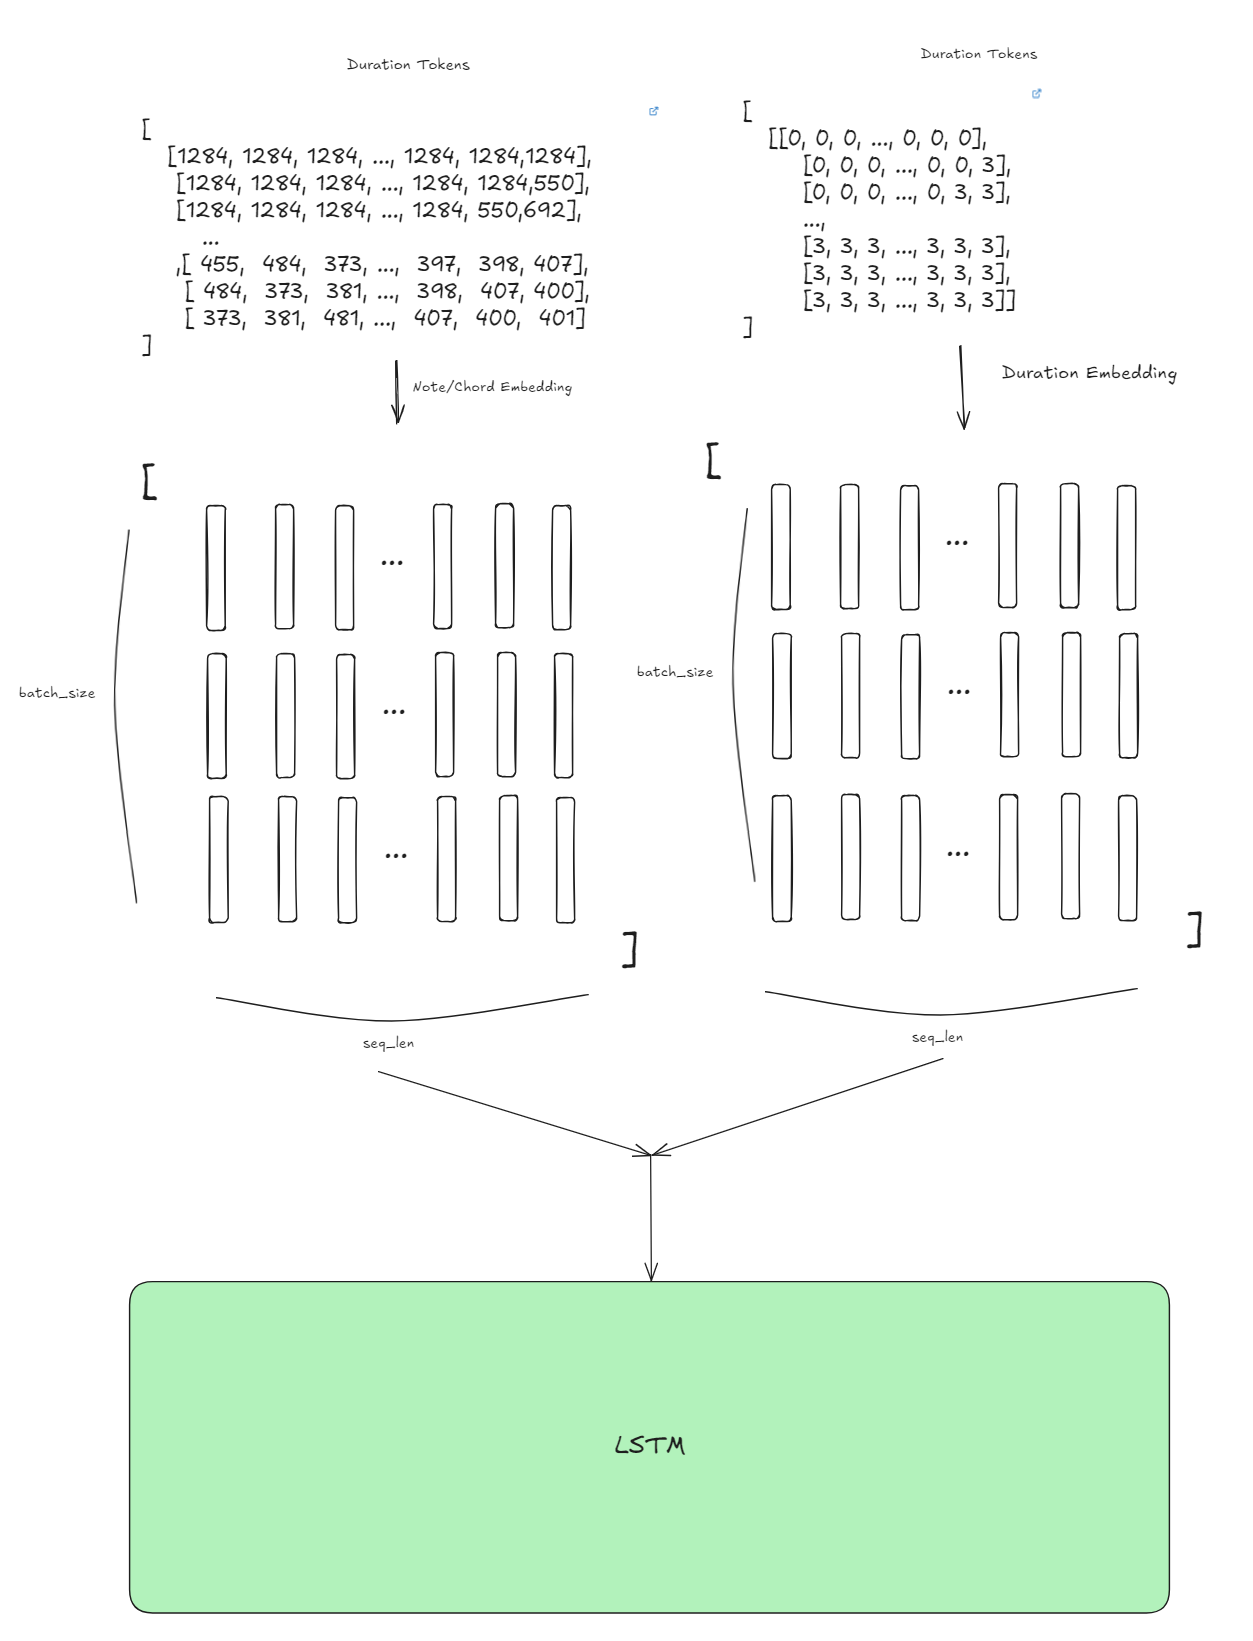

Reference: https://www.kaggle.com/code/ohseokkim/music-generation-let-s-enjoy-new-music/notebook#Embedding-Note-and-Duration

In [ ]:
def prepare_sequences_supervised(notes, durations, lookups, distincts, seq_len=32):
  """
  This function will prepare the sequences of notes and durations that we use to train the LSTM neural network.

  """
  note_to_int, int_to_note, duration_to_int, int_to_duration = lookups
  note_names, n_notes, duration_names, n_durations = distincts

  notes_network_input = []
  notes_network_output = []
  durations_network_input = []
  durations_network_output = []

  # create input sequences and the corresponding outputs
  for i in range(len(notes) - seq_len):
    notes_sequence_in = notes[i:i + seq_len]
    notes_sequence_out = notes[i + seq_len]
    notes_network_input.append([note_to_int[char] for char in notes_sequence_in])
    notes_network_output.append(note_to_int[notes_sequence_out])

    durations_sequence_in = durations[i:i + seq_len]
    durations_sequence_out = durations[i + seq_len]
    durations_network_input.append([duration_to_int[char] for char in durations_sequence_in])
    durations_network_output.append(duration_to_int[durations_sequence_out])

  n_patterns = len(notes_network_input)

  # reshape the input into a format compatible with LSTM layers
  notes_network_input = np.reshape(notes_network_input, (n_patterns, seq_len))
  durations_network_input = np.reshape(durations_network_input, (n_patterns, seq_len))
  network_input = [notes_network_input, durations_network_input]

  notes_network_output = to_categorical(notes_network_output, num_classes=n_notes)
  durations_network_output = to_categorical(durations_network_output, num_classes=n_durations)
  network_output = [notes_network_output, durations_network_output]
  return (network_input, network_output)

In [ ]:
notes, durations, lookups, distincts = get_embedding_supervised(["bach"], mode="cache")
network_input, network_output = prepare_sequences_supervised(notes, durations, lookups, distincts, SEQ_LEN)

In [ ]:
lookups[1][1284]

'START'

In [ ]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch target')
print(network_output[0][0])
print('duration target')
print(network_output[1][0])

pitch input
[1284 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284
 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284 1284
 1284 1284 1284 1284]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch target
[0. 0. 0. ... 0. 0. 0.]
duration target
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


### Unsupervised

The dataset for kalman filter EM training will look like the following:

Basically it is a note based music sequence where each note is represented by a 6-dim vector(maximally).


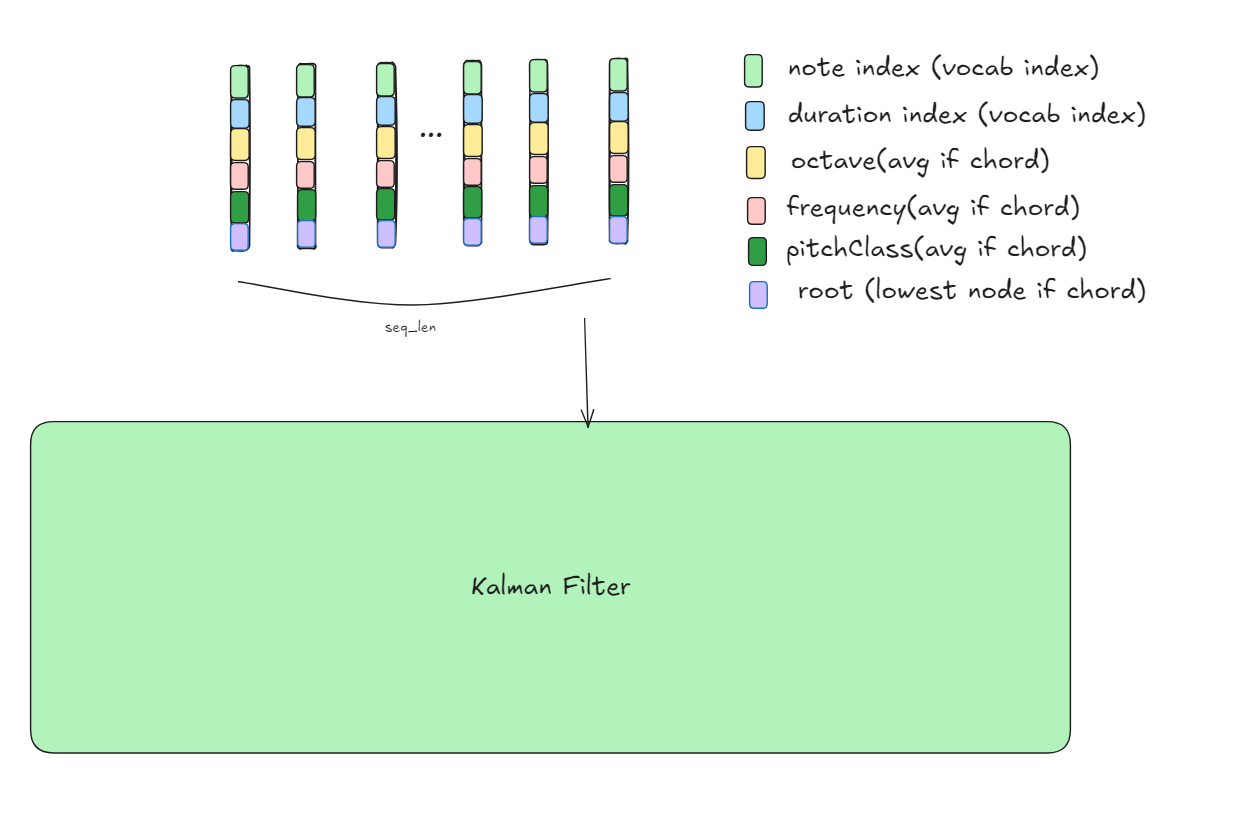

In [ ]:
def prepare_sequences_unsupervised(
    pianoists
    ,lookups
    ,model="music21"
    ,features_list = ["notes", "durations", "octave", "frequency", "pitchClass", "root"]
    ,seq_len=32):
  """
  This function will prepare the sequences of notes and durations that we use to train the LSTM neural network.


  @param pianoists: ["bach", "mozart"]
  @param lookups: [note_to_int, int_to_note, duration_to_int, int_to_duration] from get_corpus()
  @param model: Use music21(self-designed) or muspy(a third party library)
  @param seq_len: Length of input sequence.

  @returns Input data format for each midi file

  example usages:
  >>> results = extract_all_features(["bach"], mode="build")
  >>> prepare_sequences_unsupervised(["bach"], lookups)
  {'bach_847.mid': array([[4.00000000e+00, 3.21730299e+02, 1.00000000e+00, 3.68000000e+02],
        [3.00000000e+00, 1.85305917e+02, 6.00000000e+00, 1.17000000e+03],
        [4.00000000e+00, 2.93664768e+02, 2.00000000e+00, 6.64000000e+02],
        [3.33333333e+00, 2.20896065e+02, 4.33333333e+00, 7.04000000e+02],
        ...)
  'back_846.mid': array([[4.00000000e+00, 3.21730299e+02, 1.00000000e+00, 3.68000000e+02],
        [3.00000000e+00, 1.85305917e+02, 6.00000000e+00, 1.17000000e+03],
        [4.00000000e+00, 2.93664768e+02, 2.00000000e+00, 6.64000000e+02],
        [3.33333333e+00, 2.20896065e+02, 4.33333333e+00, 7.04000000e+02],)
        ,
  ...}
  """

  sequence_dict = {}

  if model == "music21":
    assert features_list is not None and len(features_list) > 0
    features = extract_all_features(pianoists, features_list, mode="cache")

    for midi_file, feature_dict in features.items():
      used_features = feature_dict.keys()
      input_seq = np.zeros((seq_len, len(used_features)))
      for i in range(32):
        for j, feature in enumerate(used_features):
          if feature == "notes" or feature == "root":
            input_seq[i][j] = lookups[0][feature_dict[feature][i]]
          elif feature == "durations":
            input_seq[i][j] = lookups[2][feature_dict[feature][i]]
          else:
            input_seq[i][j] = feature_dict[feature][i]

      sequence_dict[midi_file] = input_seq

    return sequence_dict
  elif model == "muspy":
    for pianoist in pianoists:
      for midi_file in os.listdir(os.path.join(DATA_PATH, "midi", pianoist)):
        music_obj = muspy.read_midi(os.path.join(DATA_PATH, "midi", pianoist, midi_file))
        note_representation = music_obj.to_note_representation() # List of (time, pitch, duration, velocity), 4维的向量encoding
        # to_event_representation() 1 dim, not recommended
        # to_pianoroll_representation() 128 dim
        # to_pitch_representation() 1 dim, not recommended
  else:
    raise ValueError("Invalid model")

  return sequence_dict

In [ ]:
results = extract_all_features(["bach"], mode="cache")

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
bach847 = prepare_sequences_unsupervised(["bach"], lookups)["bach_847.mid"]
bach847_half = [sublist[:400] for sublist in bach847]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
training_data = np.array(bach847_half)

# Models


## Kalman Filter

In [ ]:
class KalmanFilter:
    """Class that implements the Kalman Filter for our LDS model.

    Args:
        sigma_w: Standard deviation of latent space noise.
        sigma_v: Standard deviation of observation noise.
        a: Magnitude of latent space transition matrix.
        c: Magnitude of the observation matrix.
        dim_z: Dimension of latent space.
        dim_x: Dimension of observation space.
        sigma_w_zero: Initial standard deviation of the zero state.
        mu_zero: Initial mean of the zero state.
    """
    def __init__(self, sigma_w: float, sigma_v: float, a: float, c: float, dim_z: int,
                 dim_x: int, sigma_w_zero: float, mu_zero: np.ndarray):
        """Initialize our class."""
        # Save a few variables for bookkeeping
        self.dim_x = dim_x
        self.dim_z = dim_z

        # Used in the EM function.
        self.smooth_matrices = None # The F_t matrices from the notes. Will need to be saved.

        # TODO: Implement the transition, observation, and noise covariance matrices.
        self.transition_covariance = np.diag([sigma_w **2] * dim_z)
        self.observation_covariance = np.diag([sigma_v**2] * dim_x)
        self.transition_matrix = np.diag([a] * dim_z)
        self.observation_matrix = np.diag([c] * dim_x)

        # TODO: Implement the initial covariance and mean of the zero state.
        self.mu_zero = mu_zero
        self.cov_zero = np.diag([sigma_w_zero ** 2] * dim_z)

    def filter(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the filtered mean and covariances of the latent space.

        Args:
            data: Observations with shape [n_observations, dim_x]

        Returns:
            Filtered mean and covariance for the latent space. The first dimension
            of both should by n_observations+1 since the initial latent state has no
            paired observation.
            - filtered_means:  mu_{t}|{t} where t = 0, ..., n_observations
            - filtered_covs: sigma_{t}|{t} where t = 0, ..., n_observations
         """

        # Make sure the dimensions match and create some placeholders for the outputs.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x
        filtered_means = np.zeros((n_observations + 1, self.dim_z))
        filtered_covs = np.zeros((n_observations + 1, self.dim_z, self.dim_z))

        filtered_mean = self.mu_zero
        filtered_cov = self.cov_zero
        filtered_means[0] = filtered_mean
        filtered_covs[0] = filtered_cov
        # TODO: Implement filtering.
        for i in range(1, n_observations + 1):
            mu_t_temp = self.transition_matrix @ filtered_mean
            sigma_t_temp = self.transition_covariance + self.transition_matrix @ filtered_cov @ self.transition_matrix.T
            k_t = sigma_t_temp @ self.observation_matrix.T \
                @ np.linalg.inv(self.observation_matrix
                                @ sigma_t_temp
                                @ self.observation_matrix.T + self.observation_covariance)
            x_t = data[i - 1]
            filtered_mean = mu_t_temp + k_t @ (x_t - self.observation_matrix @ mu_t_temp)
            filtered_cov = sigma_t_temp - k_t @ self.observation_matrix @ sigma_t_temp
            filtered_means[i] = filtered_mean
            filtered_covs[i] = filtered_cov

        return filtered_means, filtered_covs

    def smooth(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the smoothed mean and covariances of the latent space.

        Args:
            data: Observations with shape [n_observations, dim_x]

        Returns:
            Smoothed mean and covariance for the latent space. The first dimension
            of both should by n_observations+1 since the initial latent state has no
            paired observation.

        Notes:

        """
        # Validate the data dimensions.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x

        # Run the forward path
        filtered_means, filtered_covs = self.filter(data)

        # Create holders for outputs
        smoothed_means = np.zeros((n_observations + 1, self.dim_z))
        smoothed_covs = np.zeros((n_observations + 1, self.dim_z, self.dim_z))
        self.smooth_matrices = np.zeros((n_observations + 1, self.dim_z, self.dim_z))



        # TODO: Implement smoothing.
        smoothed_mean = filtered_means[-1]
        smoothed_cov = filtered_covs[-1]
        smoothed_means[-1] = smoothed_mean
        smoothed_covs[-1] = smoothed_cov

        # For completeness
        self.smooth_matrices[n_observations] = self.transition_covariance + self.transition_matrix @ filtered_covs[-1] @ self.transition_matrix.T

        for i in range(n_observations - 1, -1, -1):
            # sigma_{t+1}|{t}
            sigma_t_temp_1 = self.transition_covariance + self.transition_matrix @ filtered_covs[i] @ self.transition_matrix.T
            f_t = filtered_covs[i] @ self.transition_matrix.T @ np.linalg.inv(sigma_t_temp_1)
            self.smooth_matrices[i] = f_t
            # mu_{t+1}|{t}
            mu_t_temp_1 = self.transition_matrix @ filtered_means[i]

            # Next_step
            smoothed_mean = filtered_means[i] + f_t @ (smoothed_mean - mu_t_temp_1)
            smoothed_cov = f_t @ (smoothed_cov - sigma_t_temp_1) @ f_t.T + filtered_covs[i]

            smoothed_means[i] = smoothed_mean
            smoothed_covs[i] = smoothed_cov


        # Did you remember to save the F_t calculations for EM?
        assert np.sum(np.abs(self.smooth_matrices)) > 0
        # Did you remember to set the last F_t calculation? We don't need it for EM,
        # but we do need it for completeness.
        assert np.sum(np.abs(self.smooth_matrices[-1])) > 0

        return smoothed_means, smoothed_covs

    def expectation_maximization(self, data: np.ndarray, n_iter: int):
        """Run the expectation-maximizaation algorithm on our LDS parameters.

        Args:
            data: Observations with shape [n_observations, dim_x].
            n_iter: The number of iterations of the expectation-maximization algorithm to run.

        Notes:
            Updates the internal representations of the LDS parameters but has no outputs.
        """
        # Validate the data dimensions.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x

        # TODO: Implement EM Iterations.
        for _ in range(n_iter):
            ### Expectation Step ###
            # Get the smoothed state for the current model parameters.
            smoothed_state_means, smoothed_state_covariances = self.smooth(data)

            # Solve for E[z_t], E[z_t z_{t-1}^T], E[z_t z_t^T] for use in EM.
            # E[z_t] -> smoothed_state_means, E[z_t z_t^T] -> smoothed_state_covariances + outer product of smoothed means
            expect_zt = smoothed_state_means
            expect_zt_zt = smoothed_state_covariances + np.einsum('ti,tj->tij', expect_zt, expect_zt)
            expect_zt_zt_minus = np.zeros((n_observations + 1, self.dim_z, self.dim_z))

            for t in range(1, n_observations + 1):
                # E[z_t z_{t-1}^T] for current iteration
                expect_zt_zt_minus[t] = self.smooth_matrices[t-1] @ smoothed_state_covariances[t] + np.outer(expect_zt[t], expect_zt[t-1])

            ### Maximization Step ###
            # Update equation for initial state mean and covariance
            self.mu_zero = expect_zt[0]  # E[z_0]
            self.cov_zero = expect_zt_zt[0] - np.outer(self.mu_zero, self.mu_zero)  # E[z_0 z_0^T] - E[z_0]E[z_0]^T

            # Update equation for transition matrix A_n and noise covariance Q_n
            sum_zt_zt_minus = np.sum(expect_zt_zt_minus[1:], axis=0)  # Sum E[z_t z_{t-1}^T]
            sum_zt_zt_minus_1 = np.sum(expect_zt_zt[:-1], axis=0)  # Sum E[z_{t-1} z_{t-1}^T]

            self.transition_matrix = sum_zt_zt_minus @ np.linalg.inv(sum_zt_zt_minus_1)  # Update A_n

            sum_zt_zt_t = np.sum(expect_zt_zt[1:], axis=0)
            self.transition_covariance = (1 / n_observations) * (
                sum_zt_zt_t
                - self.transition_matrix @ sum_zt_zt_minus.T
                - sum_zt_zt_minus @ self.transition_matrix.T
                + self.transition_matrix @ sum_zt_zt_minus_1 @ self.transition_matrix.T
            )

            # Update equation for observation matrix C_n and noise covariance R_n
            sum_xt_zt = np.einsum('ti,tj->ij', data, expect_zt[1:])  # Sum x_t E[z_t]^T
            sum_zt_zt_1 = np.sum(expect_zt_zt[1:], axis=0)  # Sum E[z_t z_t^T]

            self.observation_matrix = sum_xt_zt @ np.linalg.inv(sum_zt_zt_1)  # Update C_n

            sum_xt_xt_t = np.einsum('ti,tj->ij', data, data)  # Sum x_t x_t^T
            self.observation_covariance = (1 / n_observations) * (
                sum_xt_xt_t
                - self.observation_matrix @ sum_xt_zt.T
                - sum_xt_zt @ self.observation_matrix.T
                + self.observation_matrix @ sum_zt_zt_1 @ self.observation_matrix.T
            )


    def predict(self, n_steps: int) -> Tuple[np.ndarray, np.ndarray]:
      """Predict future states using the trained Kalman Filter model.

      Args:
          n_steps: Number of future steps to predict.

      Returns:
          Tuple containing:
          - predicted_means: Predicted means for the future latent states.
          - predicted_covariances: Predicted covariances for the future latent states.
      """
      # Initialize holders for predicted means and covariances
      predicted_means = np.zeros((n_steps, self.dim_z))
      predicted_covariances = np.zeros((n_steps, self.dim_z, self.dim_z))

      # Start with the last filtered state
      current_mean = self.mu_zero
      current_covariance = self.cov_zero

      for i in range(n_steps):
          # Predict the next mean and covariance
          next_mean = self.transition_matrix @ current_mean
          next_covariance = self.transition_matrix @ current_covariance @ self.transition_matrix.T + self.transition_covariance

          # Store the predictions
          predicted_means[i] = next_mean
          predicted_covariances[i] = next_covariance

          # Update the current state for the next iteration
          current_mean = next_mean
          current_covariance = next_covariance

      return predicted_means, predicted_covariances

## LSTM

Keras Version Reference: https://www.kaggle.com/code/ohseokkim/music-generation-let-s-enjoy-new-music/notebook#Modeling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MusicGenerationNetwork(nn.Module):
  def __init__(self, n_notes, n_durations, embed_size=100, rnn_units=256, use_attention=False):
    super(MusicGenerationNetwork, self).__init__()

    self.use_attention = use_attention


    # Embedding layers for notes and durations
    self.note_embedding = nn.Embedding(n_notes, embed_size)
    self.duration_embedding = nn.Embedding(n_durations, embed_size)

    # LSTM layers
    self.lstm1 = nn.LSTM(embed_size * 2, rnn_units, batch_first=True)
    self.lstm2 = nn.LSTM(rnn_units, rnn_units, batch_first=True)

    # Attention mechanism
    if use_attention:
      self.attention_dense = nn.Linear(rnn_units, 1)
      self.rnn_units = rnn_units

    # Output layers
    self.pitch_out = nn.Linear(rnn_units, n_notes)
    self.duration_out = nn.Linear(rnn_units, n_durations)

  def forward(self, notes_in, durations_in):
    # Embedding inputs
    note_embeddings = self.note_embedding(notes_in)
    duration_embeddings = self.duration_embedding(durations_in)

    # Concatenate embeddings
    x = torch.cat((note_embeddings, duration_embeddings), dim=-1)

    # Pass through LSTM layers
    x, _ = self.lstm1(x)

    if self.use_attention:
      x, _ = self.lstm2(x)

      # Attention mechanism
      e = torch.tanh(self.attention_dense(x))  # Energy
      alpha = F.softmax(e, dim=1)  # Attention weights
      context = torch.sum(alpha * x, dim=1)  # Context vector

      # Final outputs
      pitch_out = self.pitch_out(context)
      duration_out = self.duration_out(context)

      return pitch_out, duration_out, alpha
    else:
      _, (hidden, _) = self.lstm2(x)
      hidden = hidden[-1]  # Use the last layer's hidden state

      # Final outputs
      pitch_out = self.pitch_out(hidden)
      duration_out = self.duration_out(hidden)

      return pitch_out, duration_out

# Example of compiling and using the model
# n_notes = 128  # Number of unique notes
# n_durations = 128  # Number of unique durations
note_names, n_notes, duration_names, n_durations = distincts
embed_size = 100
rnn_units = 256
use_attention = True  # Set to False if you don't want attention

# Create model
model = MusicGenerationNetwork(n_notes, n_durations, embed_size, rnn_units, use_attention)

# Example inputs
notes_in = torch.randint(0, n_notes, (32, 10))  # (batch_size, sequence_length)
durations_in = torch.randint(0, n_durations, (32, 10))

# Forward pass
if use_attention:
  pitch_out, duration_out, attention_weights = model(notes_in, durations_in)
  print(f"Pitch output shape: {pitch_out.shape}, Duration output shape: {duration_out.shape}, Attention shape: {attention_weights.shape}")
else:
  pitch_out, duration_out = model(notes_in, durations_in)
  print(f"Pitch output shape: {pitch_out.shape}, Duration output shape: {duration_out.shape}")




Pitch output shape: torch.Size([32, 1285]), Duration output shape: torch.Size([32, 11]), Attention shape: torch.Size([32, 10, 1])


# Training

## Kalman Filter

In [ ]:
EMBED_DIM = 6

kf = KalmanFilter(sigma_w=3.0, sigma_v=2.0, a=1.0, c=1.0, dim_z=EMBED_DIM, dim_x=EMBED_DIM, sigma_w_zero=1.0, mu_zero=np.zeros((EMBED_DIM,)))
kf.expectation_maximization(training_data, 20)
smooth_latent_means, smooth_latent_covariances = kf.smooth(training_data)

NameError: name 'KalmanFilter' is not defined

## LSTM

Epoch [1/60], Train Loss: 7.7435, Val Loss: 7.5925
Validation loss decreased, model saved!
Epoch [2/60], Train Loss: 6.9529, Val Loss: 7.4884
Validation loss decreased, model saved!
Epoch [3/60], Train Loss: 6.6882, Val Loss: 7.4811
Validation loss decreased, model saved!
Epoch [4/60], Train Loss: 6.4778, Val Loss: 7.4261
Validation loss decreased, model saved!
Epoch [5/60], Train Loss: 6.2087, Val Loss: 7.4482
Epoch [6/60], Train Loss: 5.9362, Val Loss: 7.4686
Epoch [7/60], Train Loss: 5.6720, Val Loss: 7.5548
Epoch [8/60], Train Loss: 5.4306, Val Loss: 7.6369
Epoch [9/60], Train Loss: 5.2114, Val Loss: 7.6873
No improvement in validation loss for several epochs. Stopping training.


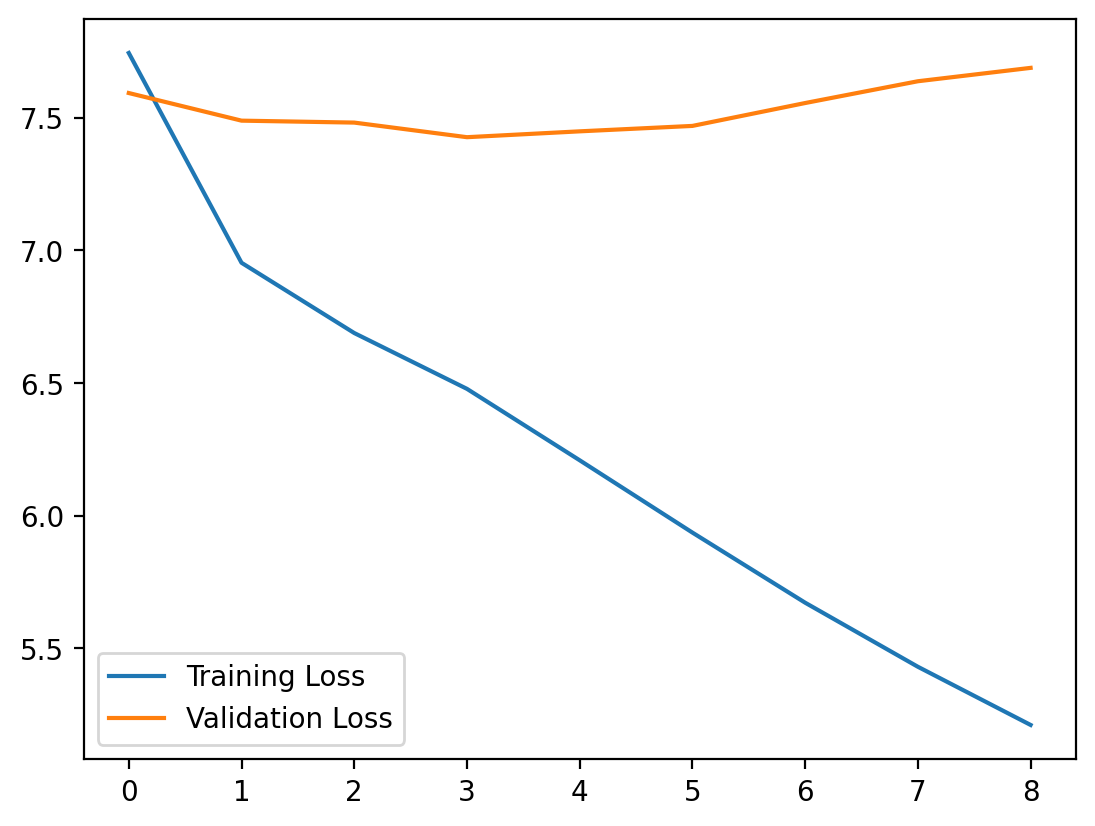

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# network_input = [notes_network_input, durations_network_input]
# network_output = [notes_network_output, durations_network_output]
# notes_network_input.shape -> (num_samples, seq_len)
# durations_network_input.shape -> (num_samples, seq_len)
# notes_network_output.shape -> (num_samples, n_notes) one-hot
# durations_network_output.shape -> (num_samples, n_durations) one-hot

class MusicDataset(Dataset):
    def __init__(self, notes_in, durations_in, notes_out, durations_out):
        self.notes_in = torch.tensor(notes_in, dtype=torch.long)
        self.durations_in = torch.tensor(durations_in, dtype=torch.long)

        self.notes_out_indices = torch.argmax(torch.tensor(notes_out, dtype=torch.float), dim=1)
        self.durations_out_indices = torch.argmax(torch.tensor(durations_out, dtype=torch.float), dim=1)

    def __len__(self):
        return len(self.notes_in)

    def __getitem__(self, idx):
        return (
            self.notes_in[idx],
            self.durations_in[idx],
            self.notes_out_indices[idx],
            self.durations_out_indices[idx],
        )

from sklearn.model_selection import train_test_split

X_notes_train, X_notes_val, X_durations_train, X_durations_val, y_notes_train, y_notes_val, y_durations_train, y_durations_val = train_test_split(
    network_input[0],
    network_input[1],
    network_output[0],
    network_output[1],
    test_size=0.2,
    random_state=0
)

batch_size = 64

train_dataset = MusicDataset(
    X_notes_train,
    X_durations_train,
    y_notes_train,
    y_durations_train
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MusicDataset(
    X_notes_val,
    X_durations_val,
    y_notes_val,
    y_durations_val
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

pitch_loss_fn = nn.CrossEntropyLoss()
duration_loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 60
best_val_loss = float('inf')
patience = 5
no_improve_epochs = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for batch in train_loader:
        notes_in_batch, durations_in_batch, notes_out_batch, durations_out_batch = batch
        notes_in_batch = notes_in_batch.to(device)
        durations_in_batch = durations_in_batch.to(device)
        notes_out_batch = notes_out_batch.to(device)
        durations_out_batch = durations_out_batch.to(device)

        optimizer.zero_grad()

        # Forward Propagation
        outputs = model(notes_in_batch, durations_in_batch)
        if model.use_attention:
            pitch_out, duration_out, _ = outputs
        else:
            pitch_out, duration_out = outputs

        loss_pitch = pitch_loss_fn(pitch_out, notes_out_batch)
        loss_duration = duration_loss_fn(duration_out, durations_out_batch)
        loss = loss_pitch + loss_duration

        # Back Propagation
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * notes_in_batch.size(0)

    avg_train_loss = total_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            notes_in_batch, durations_in_batch, notes_out_batch, durations_out_batch = batch
            notes_in_batch = notes_in_batch.to(device)
            durations_in_batch = durations_in_batch.to(device)
            notes_out_batch = notes_out_batch.to(device)
            durations_out_batch = durations_out_batch.to(device)

            outputs = model(notes_in_batch, durations_in_batch)
            if model.use_attention:
                pitch_out, duration_out, _ = outputs
            else:
                pitch_out, duration_out = outputs

            loss_pitch = pitch_loss_fn(pitch_out, notes_out_batch)
            loss_duration = duration_loss_fn(duration_out, durations_out_batch)
            loss = loss_pitch + loss_duration

            total_val_loss += loss.item() * notes_in_batch.size(0)

    avg_val_loss = total_val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_music_model.pth")
        print("Validation loss decreased, model saved!")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("No improvement in validation loss for several epochs. Stopping training.")
            break

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
note_names, n_notes, duration_names, n_durations = distincts
note_to_int, int_to_note, duration_to_int, int_to_duration = lookups

model = MusicGenerationNetwork(
    n_notes=n_notes,
    n_durations=n_durations,
    embed_size=100,
    rnn_units=256,
    use_attention=True
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

model.load_state_dict(torch.load("best_music_model.pth", map_location=device))
model.eval()

seed_length = SEQ_LEN
seed_notes = [note_to_int["START"]] * seed_length
seed_durations = [duration_to_int[0]] * seed_length

seed_notes_tensor = torch.tensor(seed_notes, dtype=torch.long).unsqueeze(0).to(device)
seed_durations_tensor = torch.tensor(seed_durations, dtype=torch.long).unsqueeze(0).to(device)

generated_notes = seed_notes[:]
generated_durations = seed_durations[:]

def sample_with_temperature(logits, temperature=1.0):
    if temperature == 0:
        return torch.argmax(logits, dim=-1).item()
    else:
        logits = logits / temperature
        probabilities = torch.softmax(logits, dim=-1)
        probabilities = probabilities.squeeze().cpu().numpy()
        return np.random.choice(len(probabilities), p=probabilities)

temperature = 1.0

generate_length = 100
for _ in range(generate_length):
    with torch.no_grad():
        if model.use_attention:
            pitch_out, duration_out, _ = model(seed_notes_tensor, seed_durations_tensor)
        else:
            pitch_out, duration_out = model(seed_notes_tensor, seed_durations_tensor)

    predicted_note = sample_with_temperature(pitch_out, temperature)
    predicted_duration = sample_with_temperature(duration_out, temperature)

    generated_notes.append(predicted_note)
    generated_durations.append(predicted_duration)

    seed_notes_tensor = torch.tensor(generated_notes[-seed_length:], dtype=torch.long).unsqueeze(0).to(device)
    seed_durations_tensor = torch.tensor(generated_durations[-seed_length:], dtype=torch.long).unsqueeze(0).to(device)

generated_note_names = [int_to_note[idx] for idx in generated_notes]
generated_note_durations = [int_to_duration[idx] for idx in generated_durations]

s = stream.Stream()

for pitch_name, dur in zip(generated_note_names, generated_note_durations):
    if pitch_name == "START":
        continue
    elif pitch_name == "rest":
        n = note.Rest()
        n.duration = duration.Duration(float(dur))
        s.append(n)
    elif '.' in pitch_name:
        pitches = pitch_name.split('.')
        chord_obj = chord.Chord(pitches)
        chord_obj.duration = duration.Duration(float(dur))
        s.append(chord_obj)
    else:
        n = note.Note(pitch_name)
        n.duration = duration.Duration(float(dur))
        s.append(n)


midi_filename = 'generated_music_847.mid'
s.write('midi', fp=midi_filename)
print(f"Music generation completed! Saved as {midi_filename}.")

def compute_metrics(music):

  measure_resolution = 24 # consistent with above

  metrics = {}
  #metrics['pitch_range'] = muspy.pitch_range(music)
  metrics['pitch_entropy'] = muspy.pitch_entropy(music) # Diversity of notes/chords over all octaves
  metrics['pitch_class_entropy'] = muspy.pitch_class_entropy(music) # Diversity of notes/chords within one octave
  #metrics['n_pitches_used'] = muspy.n_pitches_used(music)
  #metrics['n_pitch_classes_used'] = muspy.n_pitch_classes_used(music)
  #metrics['polyphony'] = muspy.polyphony(music)
  metrics['polyphony_rate'] = muspy.polyphony_rate(music) #Proportion of time during the piece when more than one note is played simultaneously
  #metrics['empty_beat_rate'] = muspy.empty_beat_rate(music)
  #metrics['empty_measure_rate'] = muspy.empty_measure_rate(music, measure_resolution)
  metrics['scale_consistency'] = muspy.scale_consistency(music) #Are all notes within a scale, is there any dissonance?
  metrics['groove_consistency'] = muspy.groove_consistency(music, measure_resolution)

  return metrics

def load_music_from_midi(midi_file):
    return muspy.read_midi(midi_file)

music = load_music_from_midi(midi_filename)

metrics = compute_metrics(music)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

s.show('midi')


Music generation completed! Saved as generated_music_847.mid.
pitch_entropy: 4.955003753768822
pitch_class_entropy: 3.3212093055852754
polyphony_rate: 0.9207920792079208
scale_consistency: 0.816
groove_consistency: 0.9992495678139243


In [ ]:
filtered_note_names = [n for n in generated_note_names if n != "START"]
play_notes(filtered_note_names)

In [ ]:
s.show('midi')


In [ ]:
play_notes_with_duration(filtered_note_names, generated_note_durations)

# Testing

## Prediction

In [ ]:
def result_decoder(prediction_mean):
  """Convert prediction mean into usable format data."""

  prediction_processed = prediction_mean.copy()
  prediction_processed = np.floor(prediction_processed)

  notes = prediction_processed[:, 0]
  durations = prediction_processed[:, 1]

  notes_strings = [lookups[1][note] for note in notes]
  durations_strings = [lookups[3][duration] for duration in durations]


  return notes_strings, durations_strings

def note_name_to_midi_number(note_name):
    return note.Note(note_name).pitch.midi

def convert_to_muspy(notes, durations, instrument=0, velocity=100):
  """Converts notes and durations to a Muspy Music object.

  Args:
    notes: A list of MIDI note numbers.
    durations: A list of note durations in seconds.
    instrument: The instrument number (default: 0 for piano).
    velocity: The velocity of the notes (default: 100).

  Returns:
    A Muspy Music object.


  sample usage:
  sample = convert_to_muspy(prediction[0], prediction[1], instrument=0, velocity=100)
  sample_original = convert_to_muspy(results['bach_847.mid']['notes'][300:450], results['bach_847.mid']['durations'][300:450])
  compute_metrics(sample), compute_metrics(sample_original)
  evaluation_metrics(compute_metrics(sample), compute_metrics(sample_original), weights = None, normalization = False)
  """

  music = muspy.Music(resolution=24) # Resolution typically is 24 or 480

  track = muspy.Track(program=instrument, is_drum=False)

  time = 0


  for note_or_chord, duration in zip(notes, durations):
    duration_ticks = int(duration * music.resolution * 4)

    if '.' in note_or_chord:   # Check if it's a chord
      pitches = [p for p in note_or_chord.split('.')]  # Split the chord into its components
      pitch_num = [note_name_to_midi_number(note) for note in pitches]
      for pitch in pitch_num:
        note_obj = muspy.Note(time=time, pitch=pitch, duration=duration_ticks, velocity=velocity)
        track.notes.append(note_obj)

      time += duration_ticks
    else:  # It's a single note
      note_obj = muspy.Note(time=time, pitch=note_name_to_midi_number(note_or_chord), duration=duration_ticks, velocity=velocity)
      track.notes.append(note_obj)
      time += duration_ticks


  music.tracks.append(track)

  return music

## Evaluation Metrics

Reference: https://muspy.readthedocs.io/en/stable/metrics.html#

In [ ]:
def compute_metrics(music):

  measure_resolution = 24 # consistent with above

  metrics = {}
  #metrics['pitch_range'] = muspy.pitch_range(music)
  metrics['pitch_entropy'] = muspy.pitch_entropy(music) # Diversity of notes/chords over all octaves
  metrics['pitch_class_entropy'] = muspy.pitch_class_entropy(music) # Diversity of notes/chords within one octave
  #metrics['n_pitches_used'] = muspy.n_pitches_used(music)
  #metrics['n_pitch_classes_used'] = muspy.n_pitch_classes_used(music)
  #metrics['polyphony'] = muspy.polyphony(music)
  metrics['polyphony_rate'] = muspy.polyphony_rate(music) #Proportion of time during the piece when more than one note is played simultaneously
  #metrics['empty_beat_rate'] = muspy.empty_beat_rate(music)
  #metrics['empty_measure_rate'] = muspy.empty_measure_rate(music, measure_resolution)
  metrics['scale_consistency'] = muspy.scale_consistency(music) #Are all notes within a scale, is there any dissonance?
  metrics['groove_consistency'] = muspy.groove_consistency(music, measure_resolution)

  return metrics


def evaluation_metrics(generated_metrics, reference_metrics, weights=None, normalization= False):
  if weights is None:
    if normalization == True:
      weights = {
          'pitch_range': 1.5,
          'pitch_entropy': 2.0,
          'pitch_class_entropy': 2.0,
          'n_pitches_used': 1.5,
          'n_pitch_classes_used': 1.5,
          'polyphony': 2.0,
          'polyphony_rate': 1.5,
          'empty_beat_rate': 1.0,
          'empty_measure_rate': 1.0,
          'scale_consistency': 1.0,
          'groove_consistency': 1.0
      }
    else:
      weights= {
      'pitch_range': 0.05,  # Reduced weight due to larger range
      'pitch_entropy': 0.1,
      'pitch_class_entropy': 0.1,
      'n_pitches_used': 0.05,
      'n_pitch_classes_used': 0.05,
      'polyphony': 0.1,
      'polyphony_rate': 1.0,  # Increased weight for smaller scale metrics
      'empty_beat_rate': 1.0,
      'empty_measure_rate': 1.0,
      'scale_consistency': 1.0,
      'groove_consistency': 1.0
      }


  # Extract metric names
  metric_names = list(generated_metrics.keys())

  if normalization:
      # Combine metrics into arrays
      generated_values = np.array(list(generated_metrics.values())).reshape(-1, 1)
      reference_values = np.array(list(reference_metrics.values())).reshape(-1, 1)

      # Stack the values for normalization
      all_values = np.vstack((generated_values, reference_values))

      # Normalize using Min-Max scaling
      scaler = MinMaxScaler()
      normalized_values = scaler.fit_transform(all_values)

      # Split back into generated and reference
      num_metrics = len(metric_names)
      normalized_generated = normalized_values[:num_metrics].flatten()
      normalized_reference = normalized_values[num_metrics:].flatten()

      # Create dictionaries with metric names and normalized values
      gen_metrics = dict(zip(metric_names, normalized_generated))
      ref_metrics = dict(zip(metric_names, normalized_reference))
  else:
      # If no normalization, use original metrics
      gen_metrics = generated_metrics
      ref_metrics = reference_metrics

  # Calculate metric differences
  metric_differences = {metric: gen_metrics[metric] - ref_metrics[metric] for metric in metric_names}

  # Calculate weighted differences
  weighted_differences = [weights[metric] * abs(metric_differences[metric]) for metric in metric_names]

  # Calculate composite score
  total_weight = sum(weights.values())
  composite_score = sum(weighted_differences) / total_weight

  return composite_score, metric_differences

In [ ]:
predicted_means, predicted_covariances = kf.predict(32)
sample = convert_to_muspy(predicted_means[0], predicted_means[1], instrument=0, velocity=100)
sample_original = convert_to_muspy(results['bach_847.mid']['notes'][300:450], results['bach_847.mid']['durations'][300:450])
compute_metrics(sample), compute_metrics(sample_original)
evaluation_metrics(compute_metrics(sample), compute_metrics(sample_original), weights = None, normalization = False)

NameError: name 'kf' is not defined